In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from src.config_reader import read_config

In [2]:
config = read_config("config/config.yaml")
raw_dir = Path(f"{config['data_ingestion']['artifact_dir']}/raw")

train_ds = pd.read_csv(raw_dir / "train.csv").sort_values(['time', 'row', 'col']).reset_index(drop=True)
train_ds.tail(5)
# val_ds = pd.read_csv(raw_dir / "val.csv")
# test_ds = pd.read_csv(raw_dir / "test.csv")


,time,row,col,demand
26925,731,7,1,0
26926,731,7,4,59
26927,731,7,5,118
26928,731,7,6,73
26929,731,7,7,14


In [3]:
train_ds = train_ds.assign(hour_of_day=train_ds['time'] % 24, day=train_ds['time'] // 24)
train_ds.head(5)

,time,row,col,demand,hour_of_day,day
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,7,33,0,0
3,0,1,3,19,0,0
4,0,1,4,14,0,0


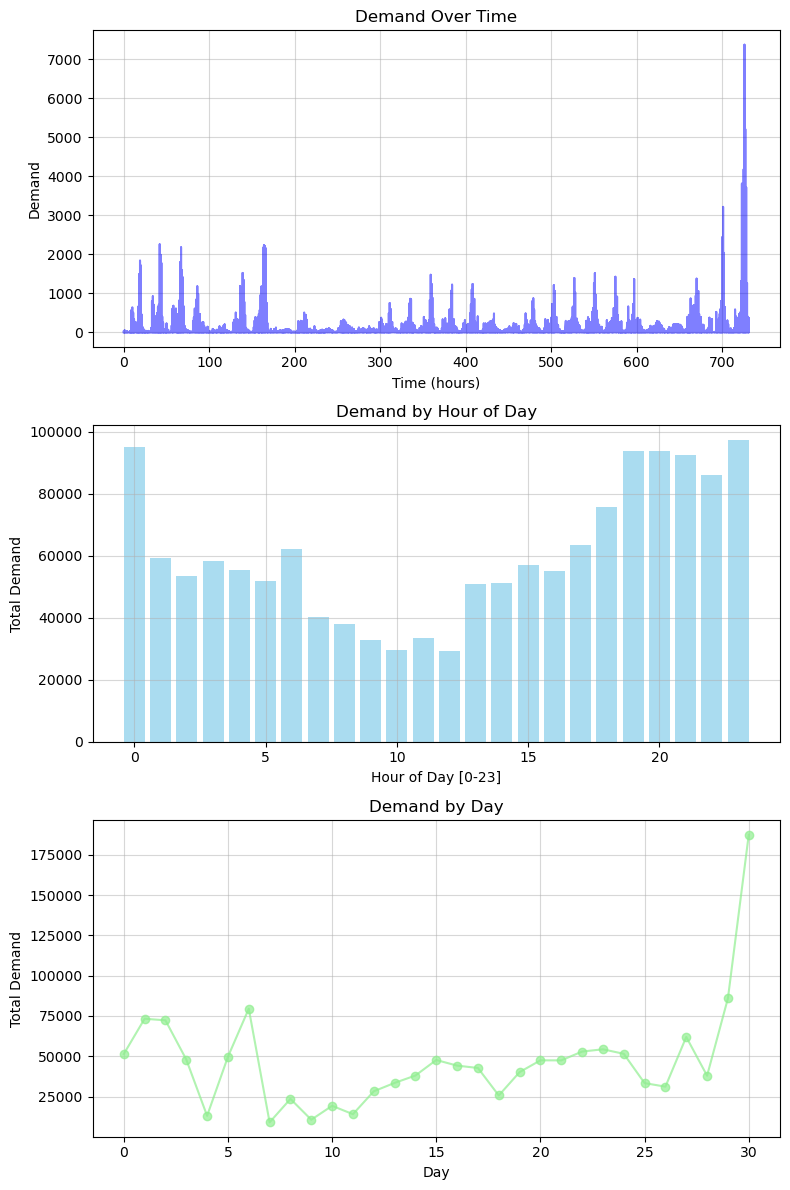

In [4]:
fix, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1: Demand over time
ax1.plot(train_ds['time'], train_ds['demand'], color='blue', alpha=0.5)
ax1.set_title('Demand Over Time')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Demand')
ax1.grid(True, alpha=0.5)

# Plot 2: Demand by Hour of Day
hourly_demand = train_ds.groupby('hour_of_day')['demand'].sum()

ax2.bar(hourly_demand.index, hourly_demand.values, color='skyblue', alpha=0.7)
ax2.set_title('Demand by Hour of Day')
ax2.set_xlabel('Hour of Day [0-23]')
ax2.set_ylabel('Total Demand')  
ax2.grid(True, alpha=0.5)

# Plot 3: Demand by Day
daily_demand = train_ds.groupby('day')['demand'].sum()

ax3.plot(daily_demand.index, daily_demand.values, color='lightgreen', alpha=0.7, marker="o")
ax3.set_title('Demand by Day')  
ax3.set_xlabel('Day')
ax3.set_ylabel('Total Demand')
ax3.grid(True, alpha=0.5)

plt.tight_layout()


Best shift: 18 hours


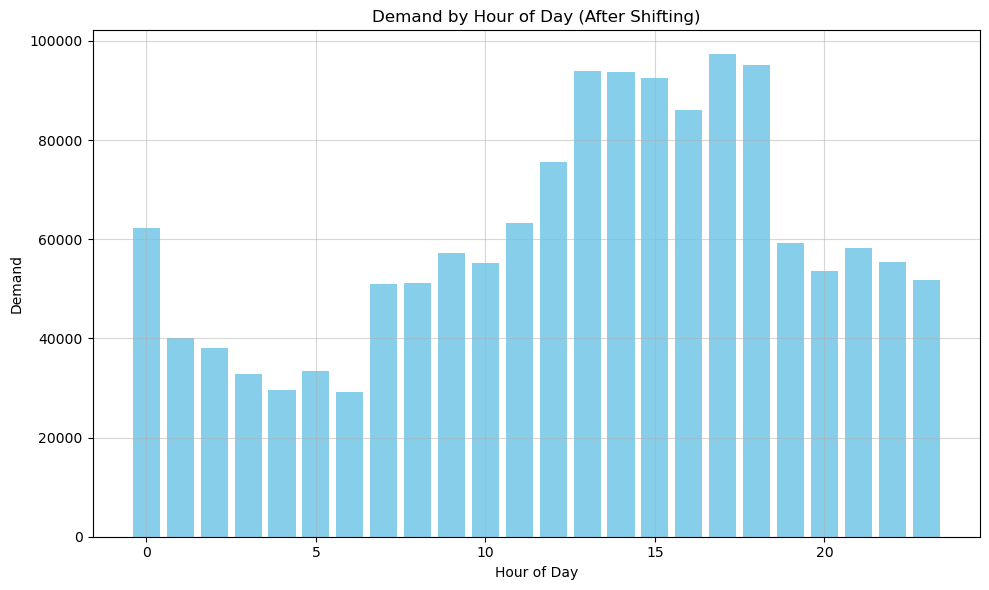

In [5]:
shifts = range(0, 24)
best_shift = 0
max_variance = float('-inf')

train_ds_sorted = train_ds.sort_values(['time']).reset_index(drop=True)

shift_monitoring = []

for shift in shifts:
    temp_df = train_ds_sorted.copy()

    temp_df['hour_of_day'] = (temp_df['time'] + shift) % 24

    peak_demand = temp_df[temp_df['hour_of_day'].isin([17, 18])]['demand'].sum()
    off_peak_demand = temp_df[temp_df['hour_of_day'].isin([3, 4])]['demand'].sum()

    variance = peak_demand - off_peak_demand

    if variance > max_variance:
        max_variance = variance
        best_shift = shift

  
train_ds_sorted['hour_of_day'] = (train_ds_sorted['time'] + best_shift) % 24
train_ds_sorted['day'] = train_ds_sorted['time'] // 24

print(f"Best shift: {best_shift} hours")

hourly_demand = train_ds_sorted.groupby('hour_of_day')['demand'].sum()

plt.figure(figsize=(10, 6))
plt.bar(hourly_demand.index, hourly_demand.values, color='skyblue')
plt.title("Demand by Hour of Day (After Shifting)")
plt.xlabel("Hour of Day")
plt.ylabel("Demand")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
